# Anomaly Detection in Web Traffic

This study is a remake of [Paul Lo
](https://medium.com/@paullo0106)'s work called [[Time Series Forecast] Anomaly detection with Facebook Prophet](https://medium.com/analytics-vidhya/time-series-forecast-anomaly-detection-with-facebook-prophet-558136be4b8d) for exercise puposes. The data used is avaible [here](https://github.com/facebook/prophet/blob/master/examples/example_wp_log_peyton_manning.csv) and notebook followed can be accessed via [here](https://github.com/Diyago/ML-DL-scripts/blob/master/time%20series%20regression/anomaly%20detection/anomaly-detection-using-facebook-s-prophet.ipynb). The aim of the exercise is to locate anomalies of the log daily page views for the Wikipedia page for [Peyton Manning](https://en.wikipedia.org/wiki/Peyton_Manning) who was a famous NFL player.

## About the Dataset

There are two columns in the dataset. "ds" stands for datetime where "y" is the hit of that day.

In [18]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


The data is collected for 2905 days historically, in between December 2007 and January, 2016.

In [19]:
print(df.shape)
print(df.ds.min())
print(df.ds.max())

(2905, 2)
2007-12-10
2016-01-20


The datatype of the date column is object, so it should be converted to "datetime". Then, we could use it as "index".

In [21]:
print(df.dtypes)
df.ds = pd.to_datetime(df.ds) # properly convert to datetime type
df.index = df.ds # make x-axis naturally appear in the datetime format

ds     object
y     float64
dtype: object


When we plotted the data, the seasonality become appearent. Notice that this is a log-transform version of the raw data, so that we donot observe abnormal spikes very much. The log-transform suppressed the violent outliers, already.

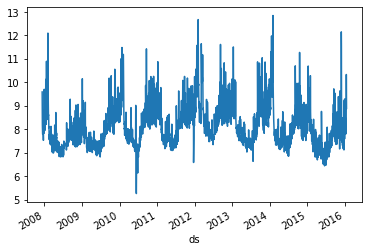

In [2]:
import matplotlib.pyplot as plt
df.y.plot()
plt.show()

## Building the Model

"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."
The uncertainties in the trend, seasonality and observed noise results in uncertainty in the prediction. Under the assumption that *the future will see similar trend changes as the history*, the FB's Prophet project the trend changes forward and by computing their distribution, thus uncertainty intervals are obtained. As it is written in the Prophet's [documentation](https://facebook.github.io/prophet/docs/uncertainty_intervals.html) "...these intervals assume that the future will see the same frequency and magnitude of rate changes as the past". This might not the case, of course.

In general, the trajectory of the time-series data changes abrubtly and Prophet automatically detect those changes and adjust the trend. Prophet does this by defining a large number of possible change points, initially and then running a L1 like normalization (sparse prior). In this way it detects where actual changes happen. Sometimes, the trend changes overfit or underfit, then sparse priority can be adjusted by using *changepoint_prior_scale*. Tuning this argument is another way of introducing uncertainty by increasing it we enable flexibility in the rate.

*Monthly* and *weekly* seasonality added to the model by defining them as a periodic signal with periods 30.5 and 7 respectively. Those signals are expanded as Fourier series which are truncated after 5th and 3rd order elements. ["The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change"](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#fourier-order-for-seasonalities).

In [25]:
from fbprophet import Prophet
# configure the model
model = Prophet(interval_width=0.95, yearly_seasonality=True, changepoint_prior_scale=0.5)
model.add_seasonality(name="monthly", period=30.5, fourier_order=5)
model.add_seasonality(name="weekly", period=7, fourier_order=3)

Then the model is fit to the historical data. To make a forecast, we need to tell Prophet how far to predict in future. *make_future_dataframe* is used to form a dataframe for the future. Here, we forcasted next 52 weeks and visualized the result.

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


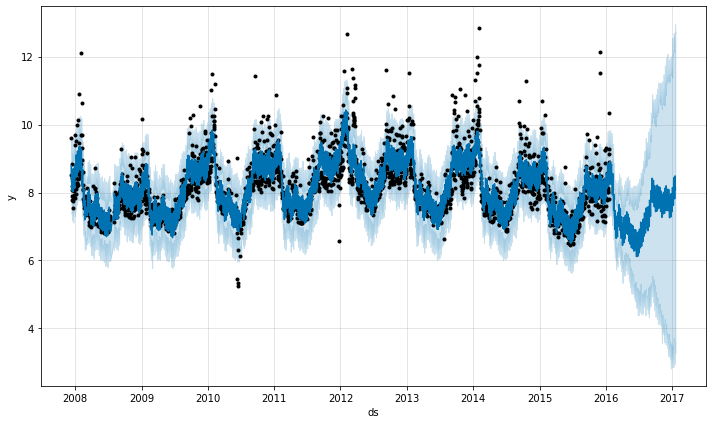

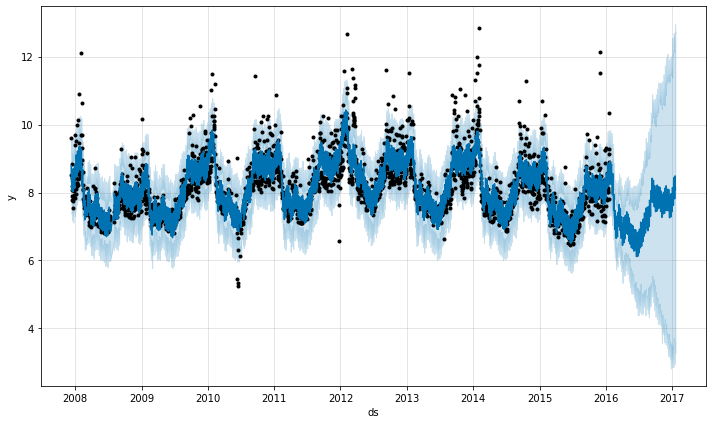

In [26]:
# fit the time-series data
model.fit(df)
# predict next 52 weeks
future = model.make_future_dataframe(periods=7*52)  
forecast = model.predict(future)
model.plot(forecast)  # visualise the result

## Detecting Outliers

The dataset is segmented into two parts with a *windows parameter*, x. Days from 0 to N-x is reserved for training and days from N-x to N are reserved for prediction. After producing the forecast for recent x days, the prediction is compared with the actual data. The data points which falls beyond the prediction interval are assumed as outliers and flagged with red color. *yhat_upper* and *yhat_lower* define the upper and lower bound of the prediction interval.

In [29]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-12-10,7.943130,7.938008,9.618674,7.943130,7.943130,0.841011,0.841011,0.841011,-0.001867,...,0.353626,0.353626,0.353626,0.489252,0.489252,0.489252,0.0,0.0,0.0,8.784141
1,2007-12-11,7.943331,7.695106,9.398413,7.943331,7.943331,0.573386,0.573386,0.573386,-0.016911,...,0.119729,0.119729,0.119729,0.470568,0.470568,0.470568,0.0,0.0,0.0,8.516717
2,2007-12-12,7.943532,7.407668,9.175417,7.943532,7.943532,0.358266,0.358266,0.358266,-0.027886,...,-0.066657,-0.066657,-0.066657,0.452809,0.452809,0.452809,0.0,0.0,0.0,8.301797
3,2007-12-13,7.943732,7.367914,9.174688,7.943732,7.943732,0.336572,0.336572,0.336572,-0.026746,...,-0.073106,-0.073106,-0.073106,0.436424,0.436424,0.436424,0.0,0.0,0.0,8.280304
4,2007-12-14,7.943933,7.440437,9.255477,7.943933,7.943933,0.340245,0.340245,0.340245,-0.011731,...,-0.069849,-0.069849,-0.069849,0.421825,0.421825,0.421825,0.0,0.0,0.0,8.284178


*profit_fit* fits the model to the time-series data and generate forecast for specified time frames; *prophet_plot* plots the actual, predictions, and anomalous values; and *get_outliers* combines the actual values and forecast in a data frame and identify the outliers.

In [28]:
from utils import prophet_fit, prophet_plot, get_outliers

### Experiment#1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Cutoff date: 2008-01-27 00:00:00
Use the data from 2007-12-10 00:00:00 to 2008-01-26 00:00:00 (48 days)
Predict 2008-01-27 00:00:00 to 2008-02-10 00:00:00 (14 days)


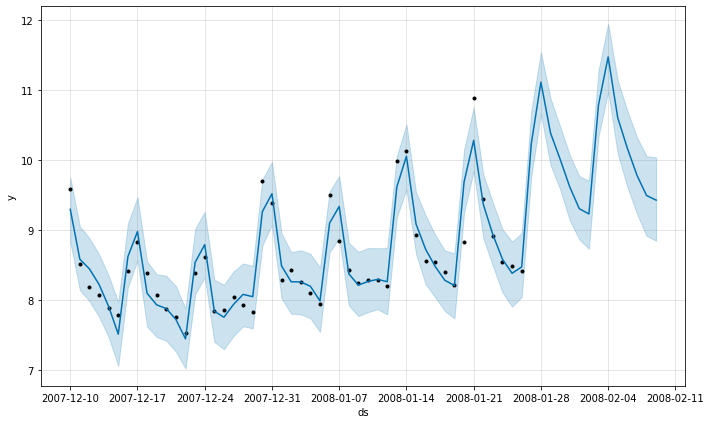

In [37]:
# Setting 1
alpha=0.95
model = Prophet(interval_width=alpha, 
                yearly_seasonality=False, 
                weekly_seasonality=False,
                changepoint_prior_scale=0.5)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
today_index = 48
print('Cutoff date:', df.index[today_index])
predict_n = 14
results = prophet_fit(df, model, today_index,
                      predict_days=predict_n)

### Experiment#2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Cutoff date: 2008-01-27 00:00:00
Use the data from 2007-12-23 00:00:00 to 2008-01-26 00:00:00 (35 days)
Predict 2008-01-27 00:00:00 to 2008-02-10 00:00:00 (14 days)


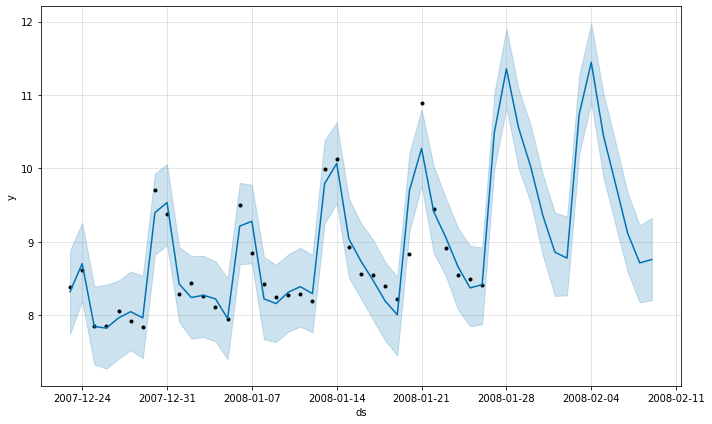

In [38]:
# Setting 2
alpha=0.98
model = Prophet(interval_width=alpha, 
                yearly_seasonality=False, 
                weekly_seasonality=False, 
                changepoint_prior_scale=0.1)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

today_index = 48
print('Cutoff date:', df.index[today_index])
predict_n = 14
lookback_n = 35
results = prophet_fit(df, model, today_index, 
                      lookback_days=lookback_n, 
                      predict_days=predict_n)

In [41]:
results.actual


AttributeError: 'tuple' object has no attribute 'actual'

In [31]:
print('Predictions')
print(df_pred.head())
df_outlier = df_pred[(df_pred.actual > df_pred.upper_y) | (df_pred.actual < df_pred.lower_y)]
print('Outliers')
print(df_outlier.head())

Predictions


NameError: name 'df_pred' is not defined

## References

+ [Example Notebook](https://github.com/paullo0106/prophet_anomaly_detection/blob/master/example.ipynb)